In [1]:
!wget https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip

--2019-12-31 17:58:20--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2019-12-31 17:58:20--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘dataset-resized.zip’

dataset-resized.zip 100%[===================>]  40.85M  --.-KB/s    in 0.1s    

2019-12-31 17:58:21 (340 MB/s) - ‘dataset-resized.zip’ saved [42834870/42834870]



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [0]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

In [5]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['trash', 'glass', 'paper', 'cardboard', 'metal', '.DS_Store', 'plastic']

In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [8]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [0]:
## apply transformations to data
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [10]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

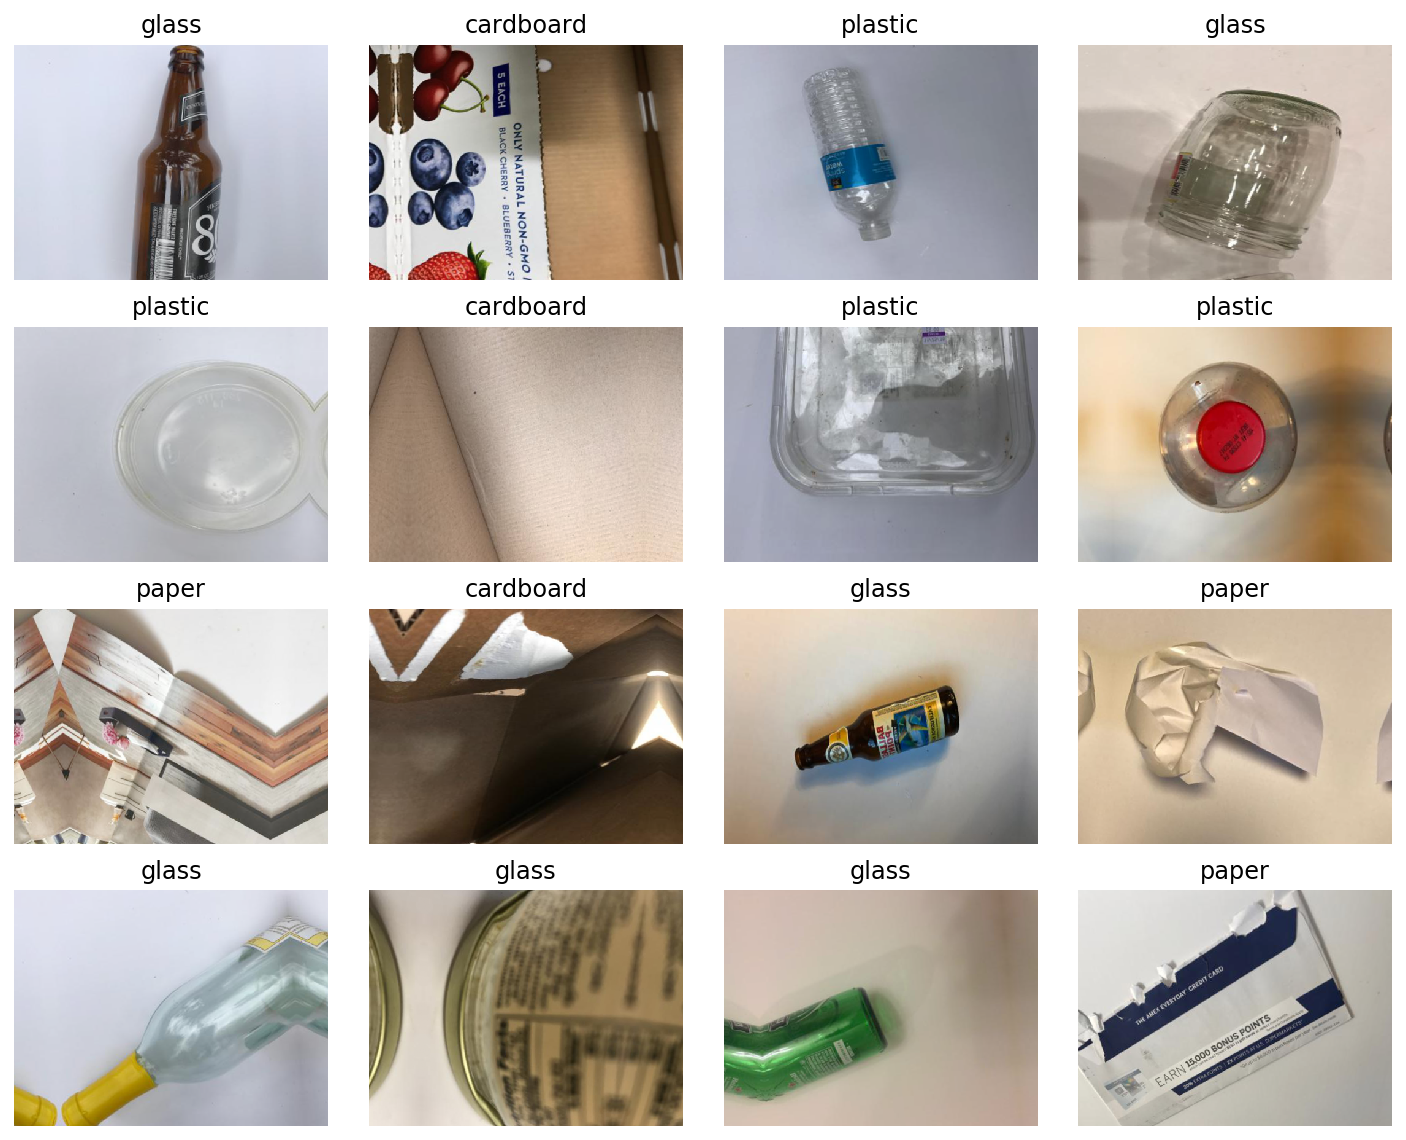

In [11]:
data.show_batch(rows=4,figsize=(10,8))

In [12]:
learn = create_cnn(data,models.alexnet,metrics=error_rate, callback_fns=ShowGraph)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:03<00:00, 71.6MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


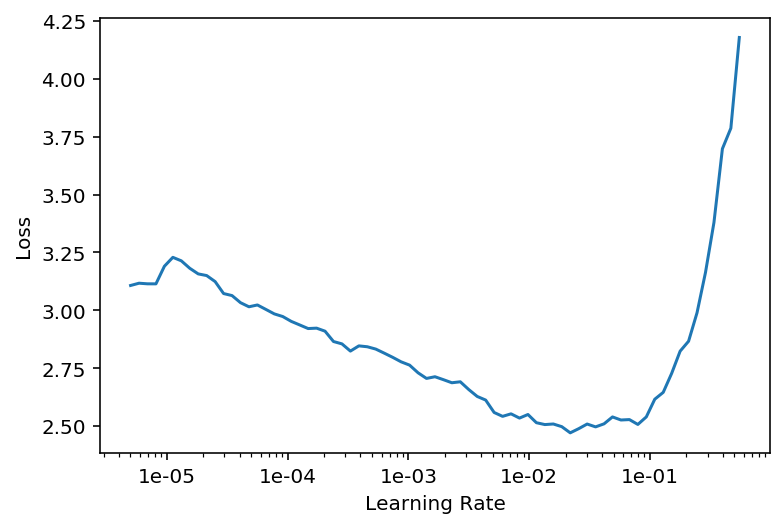

In [13]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,2.185272,1.087565,0.420635,00:34
1,1.717282,0.872454,0.304762,00:33
2,1.345663,0.835870,0.288889,00:34
3,1.301531,0.839480,0.311111,00:34
4,1.219980,0.833676,0.315873,00:34
5,1.237071,0.790476,0.293651,00:34
6,1.132376,1.065516,0.369841,00:34
7,1.178434,0.756004,0.261905,00:35
8,1.126289,0.843410,0.293651,00:34
9,1.091047,0.798416,0.300000,00:35


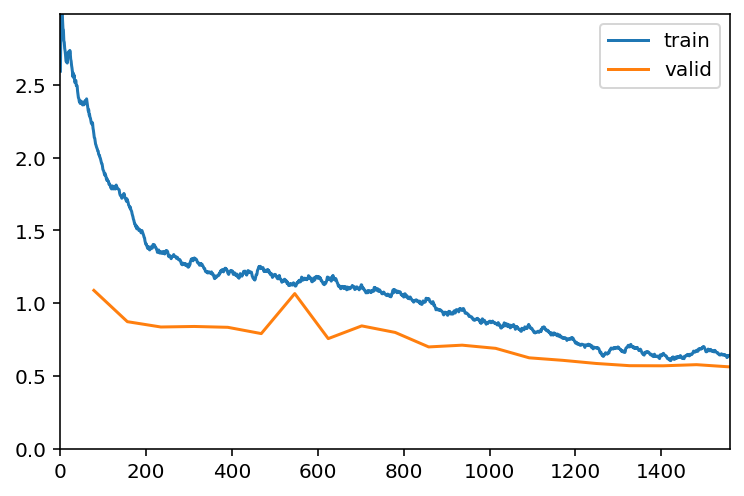

In [14]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

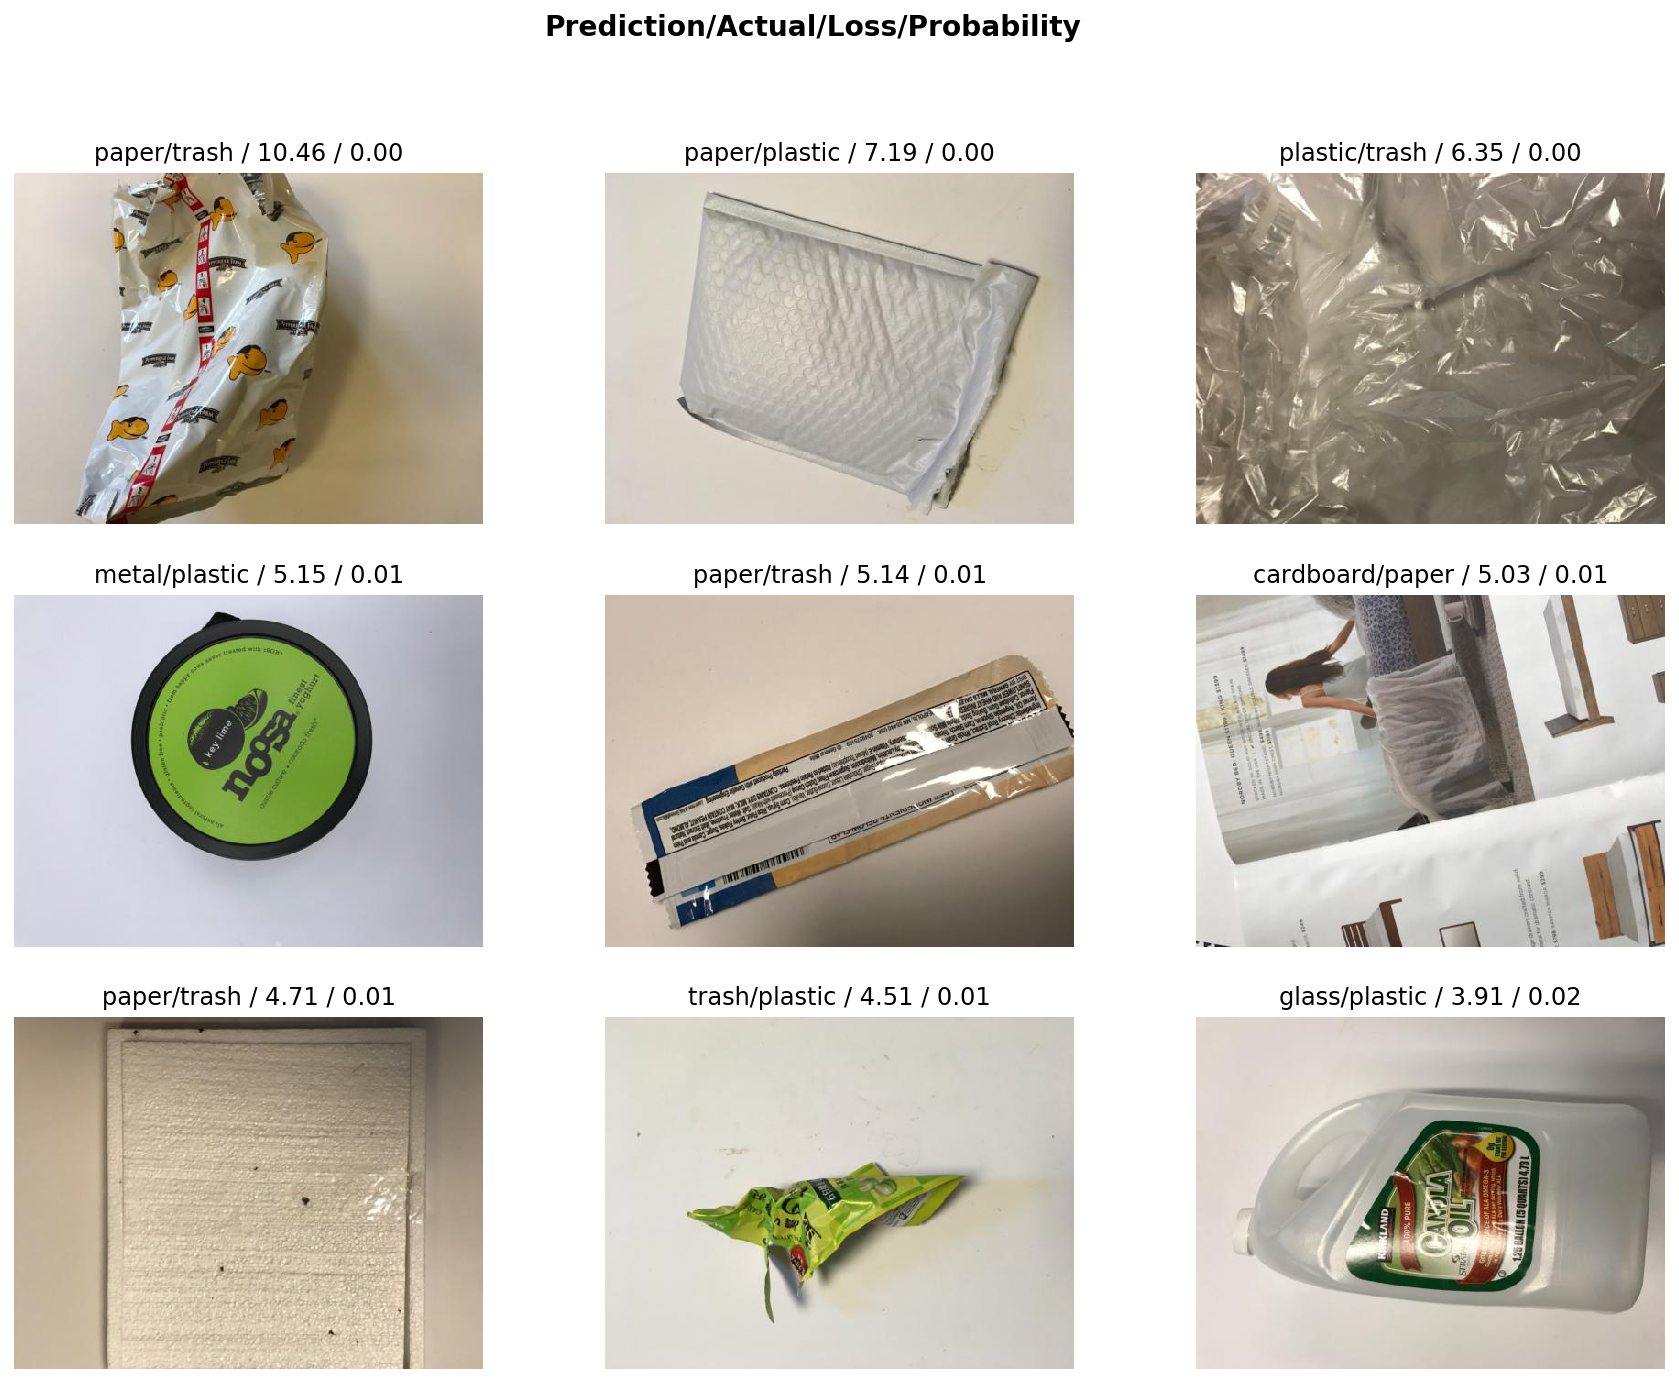

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

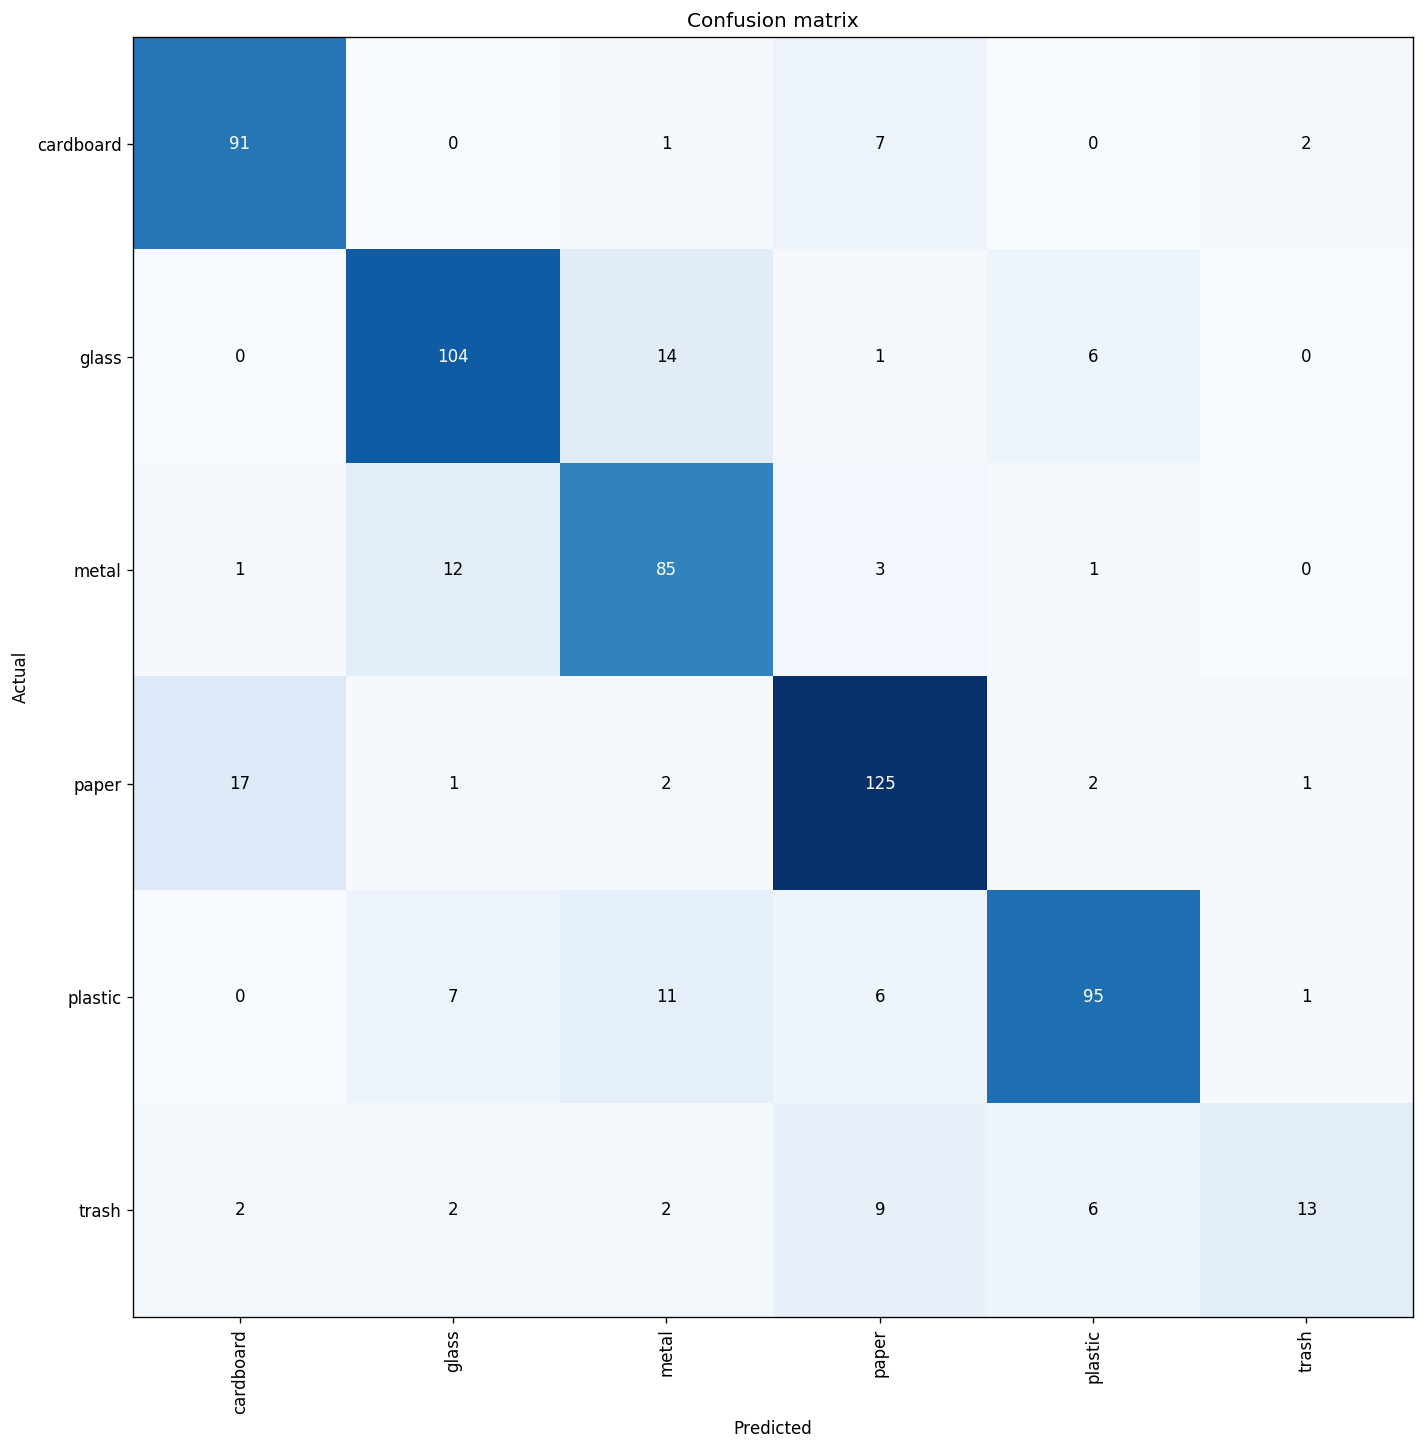

In [17]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [18]:
interp.most_confused(min_val=2)

[('paper', 'cardboard', 17),
 ('glass', 'metal', 14),
 ('metal', 'glass', 12),
 ('plastic', 'metal', 11),
 ('trash', 'paper', 9),
 ('cardboard', 'paper', 7),
 ('plastic', 'glass', 7),
 ('glass', 'plastic', 6),
 ('plastic', 'paper', 6),
 ('trash', 'plastic', 6),
 ('metal', 'paper', 3),
 ('cardboard', 'trash', 2),
 ('paper', 'metal', 2),
 ('paper', 'plastic', 2),
 ('trash', 'cardboard', 2),
 ('trash', 'glass', 2),
 ('trash', 'metal', 2)]

In [19]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [20]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[6.0516e-03, 5.0346e-01, 2.9155e-01, 9.2876e-03, 1.8483e-01, 4.8217e-03],
        [1.0395e-01, 6.7623e-03, 6.5437e-04, 8.7952e-01, 6.9943e-03, 2.1158e-03],
        [1.2207e-03, 3.0954e-06, 6.9527e-06, 9.9849e-01, 2.6073e-04, 1.5355e-05],
        ...,
        [5.0602e-01, 2.5318e-01, 2.2303e-02, 8.8286e-02, 1.2200e-01, 8.2044e-03],
        [9.9474e-01, 2.4935e-04, 4.9136e-07, 3.1392e-03, 1.8077e-03, 6.4253e-05],
        [1.9852e-04, 9.7854e-03, 3.1690e-02, 9.5350e-01, 6.4968e-04, 4.1809e-03]])

In [0]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [23]:
yhat

['glass',
 'paper',
 'paper',
 'plastic',
 'cardboard',
 'cardboard',
 'glass',
 'cardboard',
 'glass',
 'paper',
 'metal',
 'cardboard',
 'plastic',
 'paper',
 'plastic',
 'metal',
 'plastic',
 'paper',
 'cardboard',
 'cardboard',
 'plastic',
 'metal',
 'cardboard',
 'plastic',
 'paper',
 'plastic',
 'plastic',
 'paper',
 'paper',
 'paper',
 'plastic',
 'metal',
 'glass',
 'paper',
 'metal',
 'metal',
 'trash',
 'plastic',
 'metal',
 'trash',
 'glass',
 'cardboard',
 'paper',
 'metal',
 'cardboard',
 'paper',
 'trash',
 'metal',
 'metal',
 'glass',
 'metal',
 'glass',
 'glass',
 'cardboard',
 'paper',
 'cardboard',
 'cardboard',
 'paper',
 'paper',
 'plastic',
 'metal',
 'glass',
 'metal',
 'cardboard',
 'metal',
 'paper',
 'glass',
 'glass',
 'glass',
 'trash',
 'metal',
 'paper',
 'metal',
 'cardboard',
 'paper',
 'cardboard',
 'plastic',
 'metal',
 'paper',
 'metal',
 'plastic',
 'metal',
 'cardboard',
 'metal',
 'metal',
 'cardboard',
 'paper',
 'metal',
 'paper',
 'metal',
 'meta

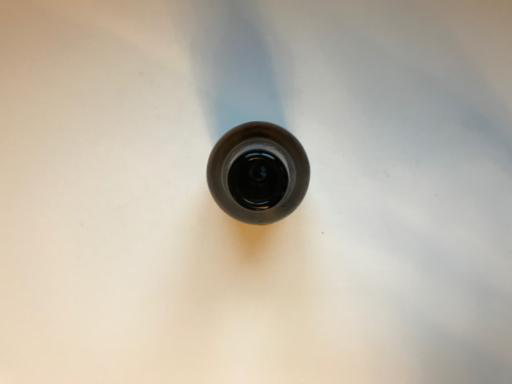

In [24]:
learn.data.test_ds[0][0]

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [26]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['glass', 'paper', 'paper', 'plastic', 'cardboard']
['glass', 'paper', 'paper', 'plastic', 'paper']


In [27]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 82   0   5  12   0   2]
 [  0  92  20   3  11   0]
 [  2  13  84   1   3   0]
 [ 10   2   0 131   3   3]
 [  1  14   2   4  96   4]
 [  2   2   1   9   7  14]]


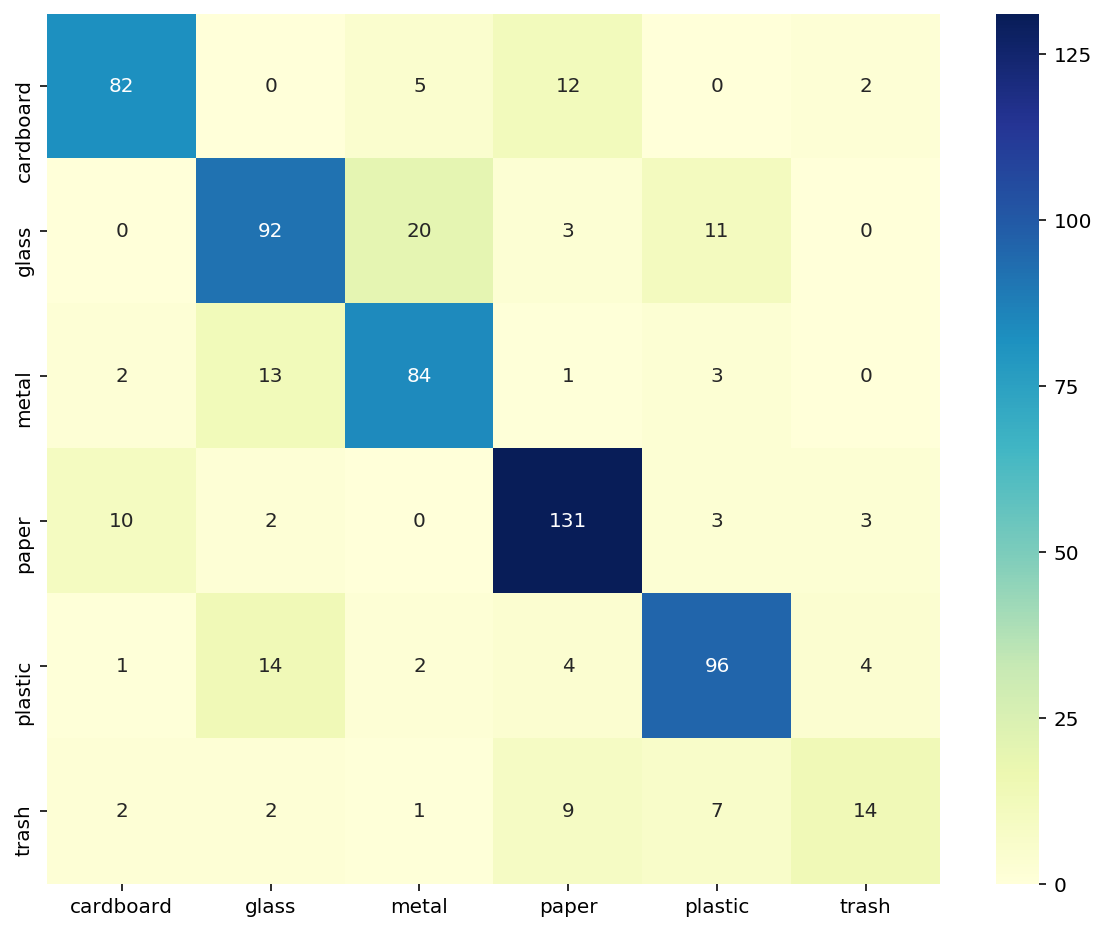

In [28]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [30]:
accuracy = correct/sum(sum(cm))
accuracy

0.7858267716535433